In [9]:
import sys
import os
import pandas as pd

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from hep_rewgt_tk.reweight_app import SingleXGBReweighter

## Pre-clean datasets

In [20]:
def apply_all(dir_name, func):
    dfA = func(pd.read_csv(f'{dir_name}/RegionA.csv', index_col=0))
    dfB = func(pd.read_csv(f'{dir_name}/RegionB.csv', index_col=0))
    dfC = func(pd.read_csv(f'{dir_name}/RegionC.csv', index_col=0))
    dfD = func(pd.read_csv(f'{dir_name}/RegionD.csv', index_col=0)) 
    return dfA, dfB, dfC, dfD

In [21]:
def keep_fake_ttbar(df):
    df = df[df.group=='TTbar']
    cond_1 = df['LDTau_genflav'] < 5
    cond_2 = df['SDTau_genflav'] < 5 
    return df[((cond_1) | (cond_2))]

In [22]:
ABCD_dir = "/Users/yuntongzhou/Desktop/Dihiggszztt/output/ABCD"
dfA, dfB, dfC, dfD = apply_all(ABCD_dir, keep_fake_ttbar)

In [24]:
# further split the data into training and testing based on mass
def split_mass(dfs):
    df = pd.concat(dfs, axis=0)
    condition = df['DiJet_mass'] > 160
    train = df[condition]
    test = df[~condition]
    return train, test

train_df, val_df = split_mass([dfA, dfB, dfC, dfD])

In [25]:
cond = train_df['OS'] == False
ss_df = train_df[cond]
os_df = train_df[~cond]

In [36]:
results_dir = "/Users/yuntongzhou/Desktop/Dihiggszztt/output"
drop_kwds = ['Gen', 'weight_values', 'Weight_values', 'OS', 'group', 'gen', 'dataset', 'label', 'btag', 'RecoH_dR', 'id', 'year']
rwgter = SingleXGBReweighter(ss_df, os_df, 'weight', results_dir)
rwgter.prep_data(drop_kwds)

Dropped  294  events with negative weights out of  38847  events.
Dropped  1168  events with negative weights out of  170072  events.
X columns: 
Index(['LDTau_pt', 'LDTau_eta', 'LDTau_phi', 'LDTau_mass', 'LDTau_dxy',
       'LDTau_dz', 'LDTau_charge', 'SDTau_pt', 'SDTau_eta', 'SDTau_phi',
       'SDTau_mass', 'SDTau_dxy', 'SDTau_dz', 'SDTau_charge', 'LDBjet_pt',
       'LDBjet_eta', 'LDBjet_phi', 'LDBjet_mass', 'SDBjet_pt', 'SDBjet_eta',
       'SDBjet_phi', 'SDBjet_mass', 'DiTau_pt', 'DiTau_eta', 'DiTau_phi',
       'DiTau_mass', 'DiJet_pt', 'DiJet_eta', 'DiJet_phi', 'DiJet_mass',
       'Tau_dR', 'Bjet_dR'],
      dtype='object')


In [37]:
rwgter.boostingSearch(20, 10, booster='dart')

[0]	train-logloss:0.49868+0.00085	train-auc:0.66276+0.00215	train-rmse:0.39899+0.00046	test-logloss:0.50013+0.00369	test-auc:0.56098+0.00231	test-rmse:0.39963+0.00207
[9]	train-logloss:0.36051+0.00378	train-auc:0.99315+0.00154	train-rmse:0.32570+0.00231	test-logloss:0.36738+0.00526	test-auc:0.98835+0.00264	test-rmse:0.32999+0.00334
Optimal number of boosting rounds: 9


In [38]:
rwgter.train(save=True, savename='trained_models/depth_20_dart_fake.json')

[0]	train-logloss:0.49869	test-logloss:0.49740
[8]	train-logloss:0.37283	test-logloss:0.37726


ROC AUC Score: 0.986
Accuracy:  0.8152736270445708


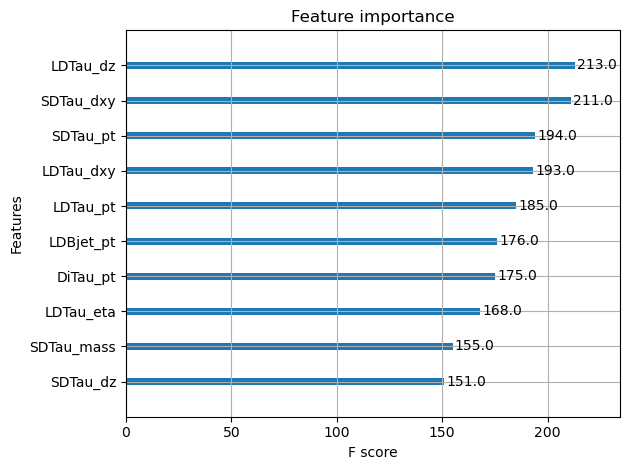

In [39]:
rwgter.evaluate()

In [40]:
# Change Naming Here
prefix = 'rwgt'
pjoin = os.path.join
savedir = pjoin('training', 'TTbar_only_fake')

In [41]:
norm_SS = ss_df['weight'].sum()
norm_OS = os_df['weight'].sum()
rwgt_SS = rwgter.reweight(ss_df, norm_OS, drop_kwds, False)

Dropped  294  events with negative weights out of  38847  events.


In [ ]:
plot_dir_name = 'TTbar_BDT'
out_dir = f'/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots/{plot_dir_name}'
data_dir = f'/Users/yuntongzhou/Desktop/Dihiggszztt/output/{savedir}'
plotter = RwgtPlotter(out_dir, data_dir)
plotter.load_rwgt(['RegionA.csv', f'{prefix}_RegionB.csv', 'RegionC.csv', f'{prefix}_RegionD.csv'])
plotter.load_ori('RegionB.csv', 'RegionD.csv')